In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from clustering import *
from gensim.models import Word2Vec
from sklearn.feature_extraction.text import TfidfVectorizer
from joblib import Parallel, delayed

In [2]:
data_small = "data/small_df/patents_df_small.csv"
data_avg = "data/average_df/patents_df_avg.csv"
data_tot = "data/total_df/patents_df_tot.csv"

df = pd.read_csv(data_tot)

In [3]:
word_counts = df["corpus"].astype(str).apply(lambda x: len(x.split()))

# Get minimum and maximum
min_words = word_counts.min()
max_words = word_counts.max()

print(f"Minimum number of words: {min_words}")
print(f"Maximum number of words: {max_words}")

Minimum number of words: 17
Maximum number of words: 90529


In [4]:
word_counts.sort_values()

3698        17
57732       17
7308        19
44612       20
41136       21
         ...  
44005    45228
17021    49123
80085    65374
51167    86787
45929    90529
Name: corpus, Length: 100001, dtype: int64

In [3]:
df = corpus_cleaning(df)

[nltk_data] Downloading package stopwords to /Users/admin/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/admin/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /Users/admin/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/admin/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


### Commonness of words within the documents

Using TF-IDF matrix computation per words and documents, we can observe that some words are highly present within the texts; it is important that for further computations this words are removed from the list. 

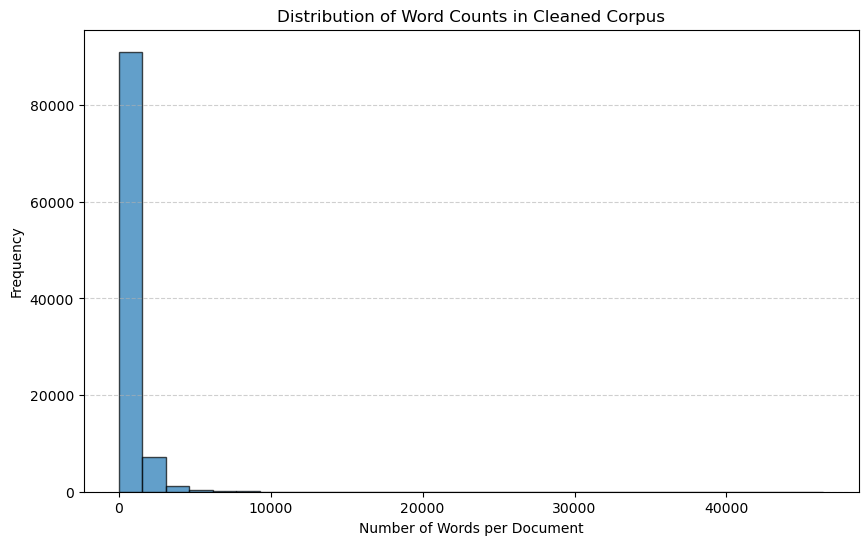

Word Count Statistics:
count    100001.000000
mean        826.982120
std         786.449493
min           8.000000
25%         431.000000
50%         629.000000
75%         959.000000
max       46382.000000
Name: word_count, dtype: float64


In [4]:
count_df = df.copy()
count_df["word_count"] = count_df["cleaned_corpus"].apply(lambda x: len(str(x).split()))

plt.figure(figsize=(10, 6))
plt.hist(count_df["word_count"], bins=30, edgecolor="black", alpha=0.7)
plt.xlabel("Number of Words per Document")
plt.ylabel("Frequency")
plt.title("Distribution of Word Counts in Cleaned Corpus")
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.show()
print("Word Count Statistics:")
print(count_df["word_count"].describe())

In [6]:
corpus = df["cleaned_corpus"].dropna().tolist()

# Compute the TF-IDF Matrix
vectorizer = TfidfVectorizer(stop_words='english', max_features=10000)
X = vectorizer.fit_transform(corpus)

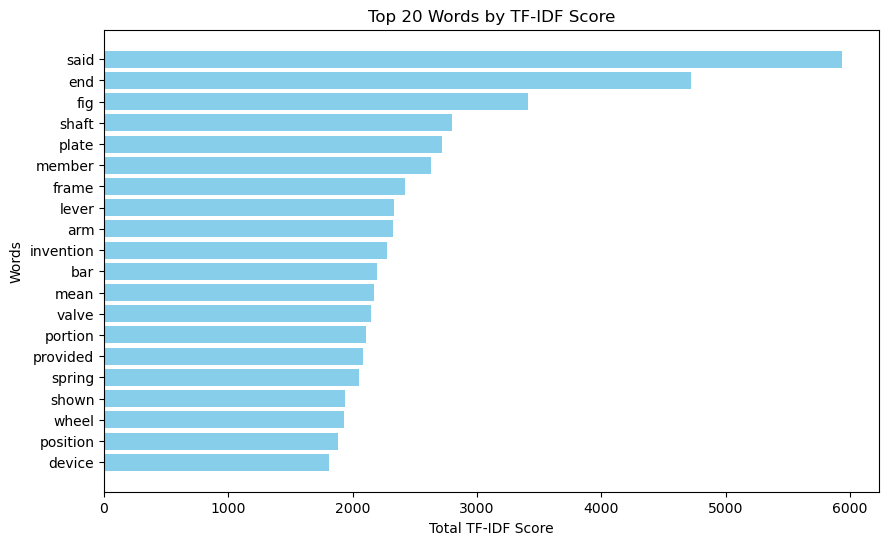

In [7]:
# Get the words and their summed tf-idf scores (accross all docs)
feature_names = vectorizer.get_feature_names_out()
word_importance = np.array(X.sum(axis=0)).flatten()

df_tfidf = pd.DataFrame({"word": feature_names, "tfidf_sum": word_importance})
df_tfidf = df_tfidf.sort_values(by="tfidf_sum", ascending=False)

# Plot the 15 words with the highest tf-idf scores
df_top_words = df_tfidf.head(20)

plt.figure(figsize=(10, 6))
plt.barh(df_top_words["word"], df_top_words["tfidf_sum"], color="skyblue")
plt.xlabel("Total TF-IDF Score")
plt.ylabel("Words")
plt.title(f"Top {20} Words by TF-IDF Score")
plt.gca().invert_yaxis()  
plt.show()

In [8]:
idf_scores = vectorizer.idf_

# We will observe all the words that appear in more than 40% of the texts. 
threshold = 40
N = X.shape[0]
DF_threshold = (threshold / 100) * N
IDF_threshold = np.log((N + 1) / (DF_threshold + 1)) + 1

df_idf_filtered = pd.DataFrame(
    [(word, idf) for word, idf in zip(feature_names, idf_scores) if 1 <= idf <= IDF_threshold],
    columns=["Word", "IDF Score"]
)

# Define the new set of stopwords (all the previous found words)
new_stop_words = set(df_idf_filtered["Word"].tolist())
print(str(len(new_stop_words)) + " words were added to the stop-words list due to really low IDF scores - meaning they were present in more than 40% of the texts.")

default_stop_words = set(TfidfVectorizer(stop_words="english").get_stop_words())
all_stop_words = list(default_stop_words.union(new_stop_words))

df_stopwords = pd.DataFrame({"stopword": all_stop_words})
df_stopwords.to_csv("data/stopwords.csv", index=False)

99 words were added to the stop-words list due to really low IDF scores - meaning they were present in more than 40% of the texts.


In [9]:
df["cleaned_corpus"] = Parallel(n_jobs=-1)(delayed(delete_stopwords)(text, new_stop_words) for text in df["cleaned_corpus"])

### OCR Errors Handling

We realize that quite a lot of words are non-existant ; meaning does not appear in the english dictionary. They could be:
- single char like "h" or "e"
- words combined with numbers "23dimethyl13but"
- words combined with each other "feedingroller"

To mitigate this issue, we will use a pre-made english words' dictionary. After trying with the nltk.words(), we realize that some common words such as "suscribing" or "dated" were not recognize. Therefore, we chose a more broad word alphabet from this resource:

wget https://raw.githubusercontent.com/dwyl/english-words/master/words_alpha.txt, which has been downloaded to *words_alpha.txt*.

In [10]:
data_small = "data/small_df/cleaned_small.csv"
data_avg = "data/average_df/cleaned_avg.csv"
data_tot = "data/total_df/cleaned_tot.csv"

df.to_csv(data_tot, index=False)